In [25]:
%reload_ext autoreload
%autoreload 2

# Jos haluaa saada keskellä koodia "pretty printin" niinkuin cellin lopussa
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from clean_velocities import *
from draw_node_amount import *
from draw_cluster_routes import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from klusterointi import *

In [2]:
df = database_query("SELECT * FROM DATA LIMIT 1000000")
df

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour
0,2,1,2020-06-25 15:21:46,28,15,628,0.962081,6812.007,3,8
1,2,1,2020-06-25 15:21:47,28,15,628,1.028834,6812.007,3,8
2,2,1,2020-06-25 15:21:47,28,15,628,0.648460,6812.007,3,8
3,2,1,2020-06-25 15:21:47,28,15,628,0.826075,6812.007,3,8
4,2,1,2020-06-25 15:21:50,26,15,626,1.753767,6812.007,3,8
...,...,...,...,...,...,...,...,...,...,...
999995,3549,10,2020-07-28 14:56:27,11,27,1091,1.050000,80.002,1,7
999996,3549,10,2020-07-28 14:56:27,11,28,1131,0.430116,80.002,1,7
999997,3549,10,2020-07-28 14:56:28,11,27,1091,1.427901,80.002,1,7
999998,3549,10,2020-07-28 14:56:28,11,27,1091,0.441022,80.002,1,7


In [79]:
distances = df1.groupby(['ajokerta'])['distance'].sum().to_dict()
df1["distance"] = df['ajokerta'].map(distances)
df1

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour,check
0,2,1,2020-06-25 15:21:46,28,15,628,334694.599082,6812.007,3,8,NaN
1,2,1,2020-06-25 15:21:47,28,15,628,334694.599082,6812.007,3,8,2.0
2,2,1,2020-06-25 15:21:47,28,15,628,334694.599082,6812.007,3,8,2.0
3,2,1,2020-06-25 15:21:47,28,15,628,334694.599082,6812.007,3,8,2.0
4,2,1,2020-06-25 15:21:50,26,15,626,334694.599082,6812.007,3,8,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2761246,8956,31,2020-09-22 14:41:04,19,16,659,NaN,97.531,1,7,8956.0
2761247,8956,31,2020-09-22 14:41:05,19,16,659,NaN,97.531,1,7,8956.0
2761248,8956,31,2020-09-22 14:41:06,18,16,658,NaN,97.531,1,7,8956.0
2761249,8956,31,2020-09-22 14:41:11,1,28,1121,NaN,97.531,1,7,8956.0


# Haetaan toisesta tietokannasta hyvät reitit

In [44]:
df1 = database_query("SELECT * FROM DATA")
df1

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour
0,2,1,2020-06-25 15:21:46,28,15,628,0.962081,6812.007,3,8
1,2,1,2020-06-25 15:21:47,28,15,628,1.028834,6812.007,3,8
2,2,1,2020-06-25 15:21:47,28,15,628,0.648460,6812.007,3,8
3,2,1,2020-06-25 15:21:47,28,15,628,0.826075,6812.007,3,8
4,2,1,2020-06-25 15:21:50,26,15,626,1.753767,6812.007,3,8
...,...,...,...,...,...,...,...,...,...,...
2761246,8956,31,2020-09-22 14:41:04,19,16,659,0.608769,97.531,1,7
2761247,8956,31,2020-09-22 14:41:05,19,16,659,0.743303,97.531,1,7
2761248,8956,31,2020-09-22 14:41:06,18,16,658,0.594138,97.531,1,7
2761249,8956,31,2020-09-22 14:41:11,1,28,1121,28.712454,97.531,1,7


In [85]:
df1 = df1.dropna()

# Muutetaan piirrematriisiksi

In [78]:
df2 = df_to_features(df1)
df2

,ajokerta,node_id,grid_id,time,kesto,dayofweek,current_hour,distance,start,end,...,15,16,17,18,19,20,21,22,23,24
0,2,1,628,2020-06-25 15:21:46,6812.007,3,8,582.077564,0,574,...,786,1091,1014,1065,869,829,1308,834,1189,866
1,3,1,630,2020-06-25 16:07:01,1121.998,3,9,219.936854,575,830,...,709,775,830,1194,1428,1423,1114,1418,1091,954
2,4,1,631,2020-06-25 17:11:26,769.999,3,10,349.979207,831,1137,...,1273,938,755,1149,634,715,1394,1034,1008,1570
3,5,1,628,2020-06-25 19:40:47,265.000,3,12,207.363103,1138,1324,...,1153,708,1448,1113,748,1034,1193,1127,1128,1354
4,7,1,629,2020-06-26 19:00:44,660.002,4,12,367.454784,1325,1588,...,1035,954,1285,1167,1009,1127,952,708,827,669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7170,8948,31,629,2020-09-18 17:48:49,645.998,4,10,NaN,2759666,2760079,...,1254,1054,658,779,1413,1333,739,699,819,1494
7171,8950,31,1041,2020-09-19 12:33:22,1239.000,5,5,NaN,2760080,2760431,...,1408,1023,932,1016,700,1011,701,1413,1014,987
7172,8954,31,632,2020-09-21 14:47:35,2287.001,0,7,NaN,2760432,2760847,...,1167,1274,1366,985,1407,1026,974,1314,1220,1388
7173,8955,31,629,2020-09-21 16:01:17,3745.999,0,9,NaN,2760848,2761180,...,788,1506,658,708,868,828,1507,976,1544,1326


In [80]:
df2 = df2.dropna()

In [89]:
df2.start = df2.start.astype('int64')
df2.end = df2.end.astype('int64')

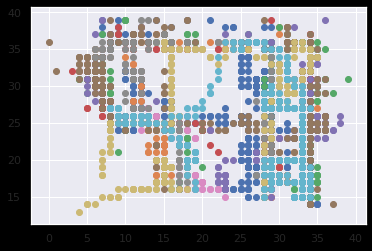

In [90]:
colors = ['red','blue','green','yellow']
for i in range (len(df2.head(10))):
    
    trip = df1.copy()[df2.start[i]:df2.end[i]]
    plt.scatter(trip.x,trip.y)
#df2.dtypes
#df2.start = df2.start.astype('int64')
#df2.end = df2.end.astype('int64')
#df2.dtypes
#plt.scatter(trip.x,trip.y)

In [ ]:
label_0 = df2.loc[df2['labels'] == 0]
label_0 = label_0.reset_index()
for i in range (len(label_0)):
    
    trip = df1.copy()[label_0.start[i]:label_0.end[i]]
    plt.scatter(trip.x,trip.y)

In [83]:
for i in range (len(df2.labels.unique())):
    
    laabelit = df2.loc[df2['labels'] == i]
    laabelit = laabelit.reset_index()
    print(i,'=',laabelit.kesto.mean())
    

0 = 454.2156577693041
1 = 3224.825830357144
2 = 5448.999000000001
3 = 731.098101978691
4 = 1835.8843398268398
5 = 5529.19887283237
6 = 1491.7268849999998
7 = 3756.304928571429


# Klusteroidaan reitit, niin että päivä korreloisi reitin keston kanssa

In [81]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = df2[['kesto','distance']]
data_std = scaler.fit_transform(data)
kmeans = KMeans()
labels = kmeans.fit_predict(data_std)
df2['labels'] = labels
df2


,ajokerta,node_id,grid_id,time,kesto,dayofweek,current_hour,distance,start,end,...,16,17,18,19,20,21,22,23,24,labels
0,2,1,628,2020-06-25 15:21:46,6812.007,3,8,582.077564,0,574,...,1091,1014,1065,869,829,1308,834,1189,866,5
1,3,1,630,2020-06-25 16:07:01,1121.998,3,9,219.936854,575,830,...,775,830,1194,1428,1423,1114,1418,1091,954,3
2,4,1,631,2020-06-25 17:11:26,769.999,3,10,349.979207,831,1137,...,938,755,1149,634,715,1394,1034,1008,1570,3
3,5,1,628,2020-06-25 19:40:47,265.000,3,12,207.363103,1138,1324,...,708,1448,1113,748,1034,1193,1127,1128,1354,0
4,7,1,629,2020-06-26 19:00:44,660.002,4,12,367.454784,1325,1588,...,954,1285,1167,1009,1127,952,708,827,669,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,3544,10,632,2020-07-27 20:16:29,2125.000,0,13,107.887927,999130,999282,...,913,793,752,1111,822,1308,1097,633,862,4
2888,3546,10,667,2020-07-28 12:42:31,317.000,1,5,201.409087,999283,999488,...,1188,1427,908,1340,1139,1059,868,788,1026,0
2889,3547,10,628,2020-07-28 13:20:11,1343.000,1,6,150.084521,999489,999735,...,1291,1293,1015,1335,1452,1456,857,1411,1252,4
2890,3548,10,627,2020-07-28 14:46:07,2380.998,1,7,125.229444,999736,999918,...,1091,698,850,1054,970,1173,1131,782,1294,4


In [38]:
palanen = df2.copy()[0:200]
palanen

,ajokerta,node_id,grid_id,time,kesto,dayofweek,current_hour,distance,0,1,...,16,17,18,19,20,21,22,23,24,labels
0,2,1,628,2020-06-25 15:21:46,6812.007,3,8,582.077564,830,634,...,1091,1014,1065,869,829,1308,834,1189,866,1
1,3,1,630,2020-06-25 16:07:01,1121.998,3,9,219.936854,894,710,...,775,830,1194,1428,1423,1114,1418,1091,954,3
2,4,1,631,2020-06-25 17:11:26,769.999,3,10,349.979207,1154,753,...,938,755,1149,634,715,1394,1034,1008,1570,3
3,5,1,628,2020-06-25 19:40:47,265.000,3,12,207.363103,1274,1087,...,708,1448,1113,748,1034,1193,1127,1128,1354,7
4,7,1,629,2020-06-26 19:00:44,660.002,4,12,367.454784,1034,703,...,954,1285,1167,1009,1127,952,708,827,669,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,216,1,627,2020-07-31 15:21:03,428.998,4,8,104.874611,1391,948,...,988,1068,941,822,902,909,1148,900,707,7
196,217,1,629,2020-07-31 16:17:53,322.000,4,9,55.367069,948,828,...,699,783,908,741,658,864,824,986,628,7
197,218,1,628,2020-07-31 18:11:27,541.000,4,11,168.863897,793,701,...,952,1048,710,1325,990,666,1016,1014,1069,7
198,219,1,667,2020-07-31 18:41:46,477.999,4,11,145.735563,970,1188,...,786,667,1207,745,1167,664,899,1427,1019,7


In [30]:
from sklearn.cluster import AgglomerativeClustering
#df2 = df_reitit[['x', 'y']].sample(n=10000, random_state=1)


potato = df2[['ajokerta','dayofweek','kesto']]
#potato = df2.copy()#df2.iloc[:,5:-1]
#potato['ajokerta'] = df2['ajokerta']

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
y_kmeans = cluster.fit_predict(potato)

potato["predicted"] = y_kmeans

ajot = df2["ajokerta"].unique()
oltava =  potato.index.unique()

poistettavat = set(ajot)-set(oltava)

data = potato[~potato['ajokerta'].isin(poistettavat)]
#print(data["ajokerta"].unique())
data["pred"] = None

zip_iterator = zip(oltava, y_kmeans)
parit = dict(zip_iterator)

df_pred = df.copy()
df_pred['pred'] = df_pred["ajokerta"].map(parit).fillna(data["pred"])
df_pred['predicted'] = df_pred["ajokerta"].map(parit).fillna(data["predicted"])
#df_pred[['x','y']] = df[['x','y']]
data['pred'] = data["ajokerta"].map(parit).fillna(data["pred"])
#data[['x','y']] = df[['x','y']]
data
df_pred

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour,check,pred,predicted
0,2,1,2020-06-25 15:21:46,28,15,628,582.077564,6812.007,3,8,NaN,3.0,3.0
1,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,3.0,3.0
2,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,3.0,3.0
3,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,3.0,3.0
4,2,1,2020-06-25 15:21:50,26,15,626,582.077564,6812.007,3,8,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3549,10,2020-07-28 14:56:27,11,27,1091,65.210473,80.002,1,7,3549.0,NaN,NaN
999996,3549,10,2020-07-28 14:56:27,11,28,1131,65.210473,80.002,1,7,3549.0,NaN,NaN
999997,3549,10,2020-07-28 14:56:28,11,27,1091,65.210473,80.002,1,7,3549.0,NaN,NaN
999998,3549,10,2020-07-28 14:56:28,11,27,1091,65.210473,80.002,1,7,3549.0,NaN,NaN


# Tiputetaan ajokerrat, jotka ei klusteroituneet

In [21]:
df_pred = df_pred.dropna()
df_pred

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour,check,pred,predicted
1,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,3,3
2,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,3,3
3,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,2.0,3,3
4,2,1,2020-06-25 15:21:50,26,15,626,582.077564,6812.007,3,8,2.0,3,3
5,2,1,2020-06-25 15:21:50,26,15,626,582.077564,6812.007,3,8,2.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3549,10,2020-07-28 14:56:27,11,27,1091,65.210473,80.002,1,7,3549.0,2,2
999996,3549,10,2020-07-28 14:56:27,11,28,1131,65.210473,80.002,1,7,3549.0,2,2
999997,3549,10,2020-07-28 14:56:28,11,27,1091,65.210473,80.002,1,7,3549.0,2,2
999998,3549,10,2020-07-28 14:56:28,11,27,1091,65.210473,80.002,1,7,3549.0,2,2


# Piirretään klusterit
## Legendissä näkyy ajokerrat, jotka löytyvät klusterista

[3 2 1 0]
Ajokerrat:  4


./Moduulit/draw_cluster_routes.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0, 1, 0.95])


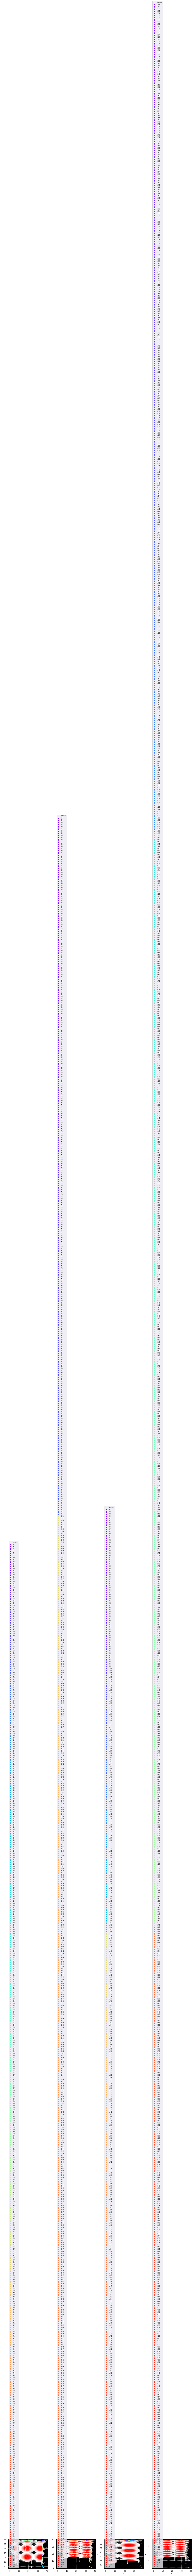

In [22]:
draw_cluster_route(df_pred, 'predicted', 'ajokerta')

Ajokerrat:  3549


ValueError: Found array with 1 sample(s) (shape=(1, 2)) while a minimum of 2 is required by AgglomerativeClustering.

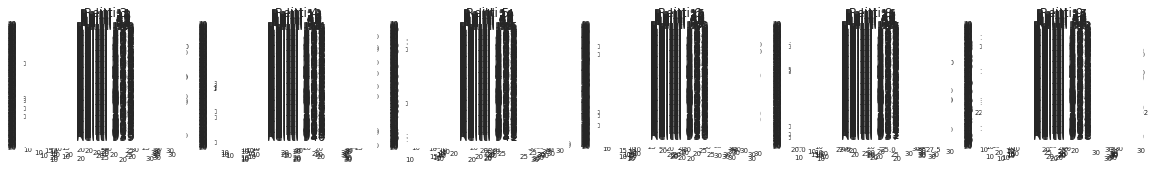

In [23]:
import matplotlib.colors as pltc
from random import sample
import matplotlib.animation as animation

def draw_cluster(df, column):
    ajot = df[column].unique()
    ajot_len = max(df[column].unique())

    print("Ajokerrat: ",ajot_len)
    
    Cols = 6

    Rows = ajot_len // Cols 
    Rows += ajot_len % Cols
    
    Position = range(1,ajot_len + 1)
    
    plt.figure(figsize=(20,10),facecolor=(1, 1, 1))
        
    #cluster.fit_predict(df)
    #plt.figure(figsize=(10, 7))
    #plt.title("Agglomerative Clustering")
    #plt.scatter(df.iloc[:,0], df.iloc[:,1], c=cluster.labels_, cmap='rainbow')

    #plt.rcParams['figure.facecolor'] = 'white'
    #fig.patch.set_facecolor('black')
    for i,k in zip(ajot,range(ajot_len)):
        df_temp = df[df[column] == i][['x', 'y']]
        cluster.fit_predict(df_temp)
        #plt.subplot((ajot_len/5)+1,6,i+1)
        plt.subplot(Rows,Cols,Position[k])
        plt.scatter(df_temp.iloc[:,0], df_temp.iloc[:,1], c=cluster.labels_, cmap='rainbow')
        #plt.plot(df[df["ajokerta"] == i]['x'], df[df["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
        #plt.scatter(in_x, in_y, color='darkorange', marker='s', s=2)
        #plt.scatter(out_x, out_y, color='green', marker='s', s=2)
        plt.title(f"Reitti {i+1}")
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        #plt.xlim(0, 40)
        #plt.ylim=(0, 40)
        #plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
draw_cluster(df_pred,'ajokerta')

# Dendogrammi
Dendrogrammi havainnollistaa, kuinka kukin klusteri koostuu piirtämällä U-muotoinen linkki ei-yksittäisen klusterin ja sen lasten välille. 

- U-lenkin yläosa osoittaa klusterin sulautumisen.
- U-lenkin kaksi osaa osoittavat, mitkä klusterit yhdistettiin. 
- U-lenkin kahden haaran pituus edustaa lapsiklustereiden välistä etäisyyttä. 
    - Se on myös kofeneettinen etäisyys kahden lapsiryhmän alkuperäisten havaintojen välillä.

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

# generate the linkage matrix
#X = df_pred[['ajokerta', 'dayofweek', 'kesto']].values
X = df2[['distance', 'current_hour']]
#X = df2
Z = linkage(X,
            method='complete',  # dissimilarity metric: max distance across all pairs of 
                                # records between two clusters
            metric='euclidean'
    )                           # you can peek into the Z matrix to see how clusters are 
                                # merged at each iteration of the algorithm

# calculate full dendrogram and visualize it
'''plt.figure(figsize=(30, 10))
dendrogram(Z)
plt.show()'''

'''# retrive clusters with `max_d`
from scipy.cluster.hierarchy import fcluster
max_d = 25       # I assume that your `Latitude` and `Longitude` columns are both in 
                 # units of miles
clusters = fcluster(Z, max_d, criterion='distance')'''

plt.figure(figsize=(30, 10))
dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                           above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()